In [1]:
# Step 1: Importing modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import requests
from io import BytesIO

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Bidirectional, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# Step 2: Function to get TPU or GPU accelerator

def get_accelerator():
    try:
        # Check for TPU
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        return tf.distribute.TPUStrategy(tpu), "TPU"
    except ValueError:
        # Check for GPU
        gpus = tf.config.list_physical_devices('GPU')
        if gpus:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            return tf.distribute.MirroredStrategy(), "GPU"
        else:
            # Default to CPU if neither TPU nor GPU is found
            return tf.distribute.get_strategy(), "CPU"

# Function to show accelerator information
def show_accelerator_info(accelerator_type):
    if accelerator_type == "TPU":
        print("Running on TPU:", tf.distribute.cluster_resolver.TPUClusterResolver().master())
    elif accelerator_type == "GPU":
        print("Running on GPU:", tf.config.list_logical_devices('GPU'))
    else:
        print("Running on CPU")

# Get the accelerator and its type
strategy, accelerator_type = get_accelerator()

# Show accelerator information
show_accelerator_info(accelerator_type)

Running on TPU: 


In [3]:
# Step 3: Download and read the dataset

print("Downloading dataset...")
url = 'https://drive.google.com/uc?id=1TJRGPWvCHzhBMA9yuYLgTywuen5cmcaX'
response = requests.get(url)
print("Download complete. Reading the dataset into a DataFrame...")

# Reading CSV data into DataFrame
data = pd.read_csv(BytesIO(response.content), low_memory=False)

# Display the first few rows of the dataset and column names
print("\nFirst few rows of the dataset:")
print(data.head())
print("\nColumn names in the dataset:")
print(data.columns)

Download complete. Reading the dataset into a DataFrame...

First few rows of the dataset:
                     id                                               name  \
0  AVqkIhwDv8e3D1O-lebb  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...   
1  AVqkIhwDv8e3D1O-lebb  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...   
2  AVqkIhwDv8e3D1O-lebb  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...   
3  AVqkIhwDv8e3D1O-lebb  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...   
4  AVqkIhwDv8e3D1O-lebb  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...   

        asins   brand                                         categories  \
0  B01AHB9CN2  Amazon  Electronics,iPad & Tablets,All Tablets,Fire Ta...   
1  B01AHB9CN2  Amazon  Electronics,iPad & Tablets,All Tablets,Fire Ta...   
2  B01AHB9CN2  Amazon  Electronics,iPad & Tablets,All Tablets,Fire Ta...   
3  B01AHB9CN2  Amazon  Electronics,iPad & Tablets,All Tablets,Fire Ta...   
4  B01AHB9CN2  Amazon  Electronics,iPad & Tablets,All Tablet

In [4]:
# Step 4: Define the text and label columns

text_column = 'reviews.text'  # Adjust to the correct column name in the dataset
label_column = 'reviews.rating'  # Adjust to a usable label column for sentiment analysis

# Extract text and labels from the DataFrame
texts = data[text_column].astype(str).tolist()  # Convert text to a list of strings
labels = data[label_column].values  # Extract labels

In [5]:
# Step 5: Define a mapping function to convert ratings to sentiments
def map_rating_to_sentiment(rating):
    if rating == 1 or rating == 2:
        return 0  # Negative
    elif rating == 3:
        return 1  # Neutral
    elif rating == 4 or rating == 5:
        return 2  # Positive
    else:
        return 1  # Default to Neutral for unknown ratings

# Apply the mapping function to create labels
labels = data[label_column].apply(map_rating_to_sentiment).values

# Display the updated DataFrame
data['sentiment'] = labels
print(data[['reviews.text', 'reviews.rating', 'sentiment']])

# Define the number of sentiment classes
num_classes = 3  # Negative, Neutral, Positive

# Verify that the number of texts matches the number of labels
assert len(texts) == len(labels), "The number of texts and labels must be the same."

                                            reviews.text  reviews.rating  \
0      This product so far has not disappointed. My c...             5.0   
1      great for beginner or experienced person. Boug...             5.0   
2      Inexpensive tablet for him to use and learn on...             5.0   
3      I've had my Fire HD 8 two weeks now and I love...             4.0   
4      I bought this for my grand daughter when she c...             5.0   
...                                                  ...             ...   
34655  This is not appreciably faster than any other ...             3.0   
34656  Amazon should include this charger with the Ki...             1.0   
34657  Love my Kindle Fire but I am really disappoint...             1.0   
34658  I was surprised to find it did not come with a...             1.0   
34659  to spite the fact that i have nothing but good...             1.0   

       sentiment  
0              2  
1              2  
2              2  
3          

In [6]:
# Step 6: Tokenize and pad sequences
max_features = 10000  # Maximum number of words to keep, based on word frequency
maxlen = 100  # Maximum length of the sequences

# Tokenize the text
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Pad sequences to ensure uniform input size
X = pad_sequences(sequences, maxlen=maxlen)

print(f"Shape of X (features) after padding: {X.shape}")  # Should print (number_of_samples, maxlen)

# Convert labels to categorical (one-hot encoding)
labels = to_categorical(labels, num_classes=num_classes)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Shape of X (features) after padding: (34660, 100)
X_train shape: (27728, 100), y_train shape: (27728, 3)
X_test shape: (6932, 100), y_test shape: (6932, 3)


In [7]:
# Step 7: Build the LSTM model
embedding_dim = 100  # Dimension of the embedding layer

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=maxlen))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(num_classes, activation='softmax'))  # Output layer with softmax activation

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

# Define early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')

# Train the model
history = model.fit(X_train, y_train,
                    epochs=10,  # Number of epochs to train
                    batch_size=64,  # Batch size
                    validation_data=(X_test, y_test),  # Validation data
                    callbacks=[early_stopping, checkpoint])  # Callbacks

print("Training complete.")

# Optionally, save the model
model.save('sentiment_model.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1455000   
                                                                 
 spatial_dropout1d (Spatial  (None, 100, 100)          0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 128)               84480     
 al)                                                             
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 1539867 (5.87 MB)
Trainable params: 1539867 (5.87 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
434/434

In [8]:
# Step 8: Evaluate model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Print metrics
print("Classification report:")
# Classification report with zero_division parameter
print(classification_report(y_true, y_pred_classes, zero_division=0))

217/217 [==============================] - 5s 21ms/step
Classification report:
              precision    recall  f1-score   support

           0       0.37      0.24      0.29       161
           1       1.00      0.01      0.01       288
           2       0.94      1.00      0.97      6483

    accuracy                           0.94      6932
   macro avg       0.77      0.41      0.42      6932
weighted avg       0.93      0.94      0.91      6932



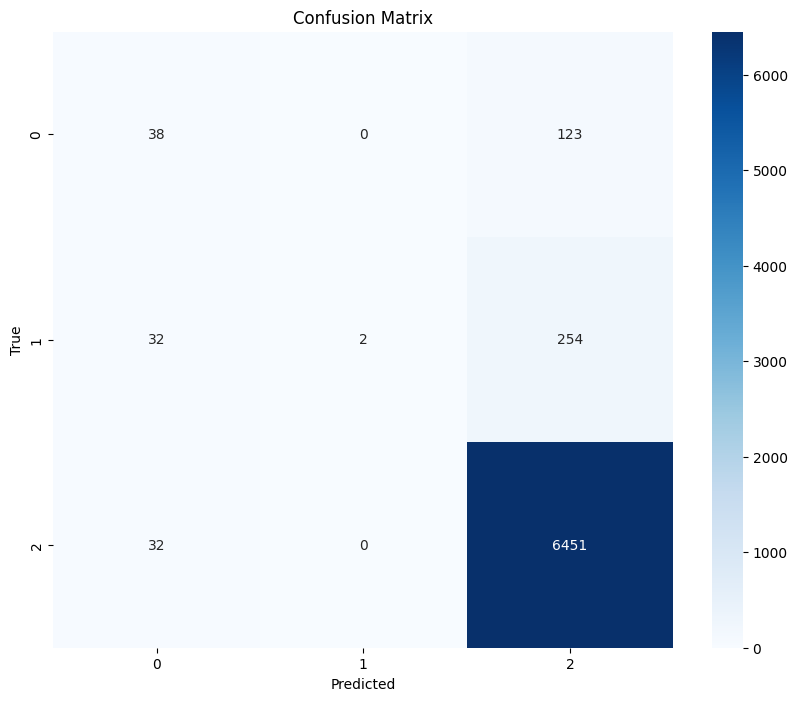

In [9]:
# Step 9: Plotting

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

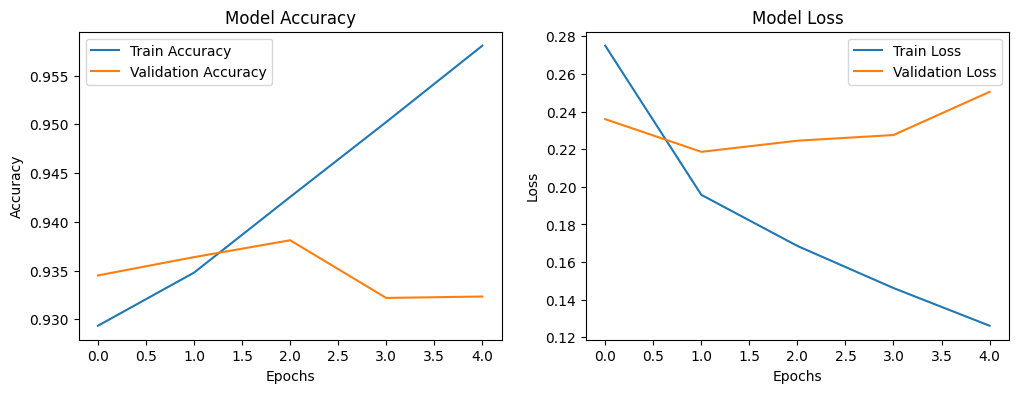

In [10]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

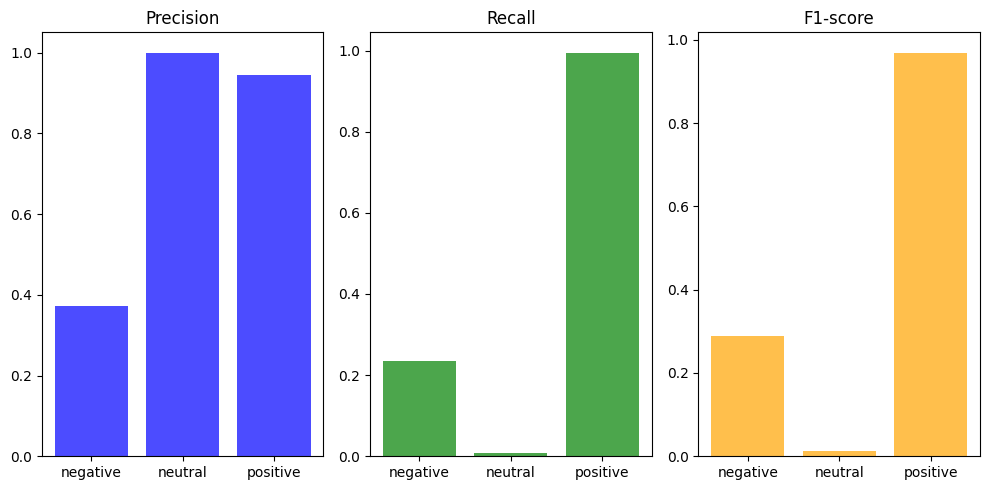

In [11]:
labels = ['negative', 'neutral', 'positive']
metrics = classification_report(y_true, y_pred_classes, target_names=labels, zero_division=0, output_dict=True)

precision = [metrics[label]['precision'] for label in labels]
recall = [metrics[label]['recall'] for label in labels]
f1 = [metrics[label]['f1-score'] for label in labels]

plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.bar(labels, precision, color='blue', alpha=0.7)
plt.title('Precision')

plt.subplot(1, 3, 2)
plt.bar(labels, recall, color='green', alpha=0.7)
plt.title('Recall')

plt.subplot(1, 3, 3)
plt.bar(labels, f1, color='orange', alpha=0.7)
plt.title('F1-score')

plt.tight_layout()
plt.show()

In [12]:
accuracy = accuracy_score(y_true, y_pred_classes)
report = classification_report(y_true, y_pred_classes, zero_division=0)
conf_matrix = confusion_matrix(y_true, y_pred_classes)

print("\n---------------------")
print("Model Performance:")
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print("---------------------")
print("Model Performance Metrics:")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{classification_report(y_true, y_pred_classes)}")
print("---------------------")


---------------------
Model Performance:
Accuracy: 0.9364
Precision: [0.37254901960784315, 1.0, 0.9447861745752782]
Recall: [0.2360248447204969, 0.006944444444444444, 0.9950640135739627]
F1-score: [0.2889733840304183, 0.013793103448275862, 0.9692735331680565]
---------------------
Model Performance Metrics:
Confusion Matrix:
[[  38    0  123]
 [  32    2  254]
 [  32    0 6451]]
Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.24      0.29       161
           1       1.00      0.01      0.01       288
           2       0.94      1.00      0.97      6483

    accuracy                           0.94      6932
   macro avg       0.77      0.41      0.42      6932
weighted avg       0.93      0.94      0.91      6932

---------------------


In [13]:
# Print full statistics
print("\n---------------------")
print("Model Training Statistics:")
print(f"Number of samples: {len(data)}")
print(f"Number of classes: {num_classes}")
print(f"Shape of features (X): {X.shape}")
print(f"Training split: {X_train.shape[0]} samples")
print(f"Validation split: {X_test.shape[0]} samples")
print("---------------------")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print("---------------------")
print("Model Evaluation Statistics:")
print(f"Test Loss: {model.evaluate(X_test, y_test)[0]:.4f}")
print(f"Test Accuracy: {model.evaluate(X_test, y_test)[1]:.4f}")
print("---------------------")
print("Model Summary:")
print(model.summary())
print("---------------------")
print("Model Training History:")
print(history.history)
print("---------------------")
print("Model Checkpoint:")
print(checkpoint)
print("---------------------")
print("Early Stopping:")
print(early_stopping)
print("---------------------")
print("Model Weights:")
print(model.get_weights())
print("---------------------")
print("Model Architecture:")
print(model.to_json())
print("---------------------")




---------------------
Model Training Statistics:
Number of samples: 34660
Number of classes: 3
Shape of features (X): (34660, 100)
Training split: 27728 samples
Validation split: 6932 samples
---------------------
X_train shape: (27728, 100), y_train shape: (27728, 3)
X_test shape: (6932, 100), y_test shape: (6932, 3)
---------------------
Model Evaluation Statistics:
217/217 [==============================] - 5s 22ms/step - loss: 0.2186 - accuracy: 0.9364
Test Loss: 0.2186
217/217 [==============================] - 5s 21ms/step - loss: 0.2186 - accuracy: 0.9364
Test Accuracy: 0.9364
---------------------
Model Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1455000   
                                                                 
 spatial_dropout1d (Spatial  (None, 100, 100)          0         
 Dropout1D)          